# ModOAP - Classification automatique d'images - Entraînement

Ce script permet d'entraîner un modèle à la classification automatique d'images, à partir de données d'entraînement (images + annotations) sur un Google Drive.

La classification est de type multiclass : à chaque image est associée une classe parmi un jeu de plusieurs étiquettes (pas de limite)

Le modèle entraîné peut ensuite être sauvegardé dans un dossier Google Drive.

Il pourra être importé pour être utilisé dans le script ModOAP - Classification automatique d'images - Prédictions.

Ce script implémente la plateforme TensorFlow : https://www.tensorflow.org/

**Ce script doit être lancé dans un environnement d'exécution GPU : Exécution -> Modifier le type d'exécution -> GPU**


In [ ]:
#@markdown ## Synchronisation d'un compte Google Drive et imports:
#@markdown Lancer cette cellule, puis cliquer sur le lien généré par Google pour connecter un compte Drive si demandé.
# Connecter un compte Drive

# Connecter un compte Drive
from google.colab import drive
drive.mount('/content/drive')

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import pathlib


### Format des données d'entraînement

Formats d'images supportés : JPG, PNG, BMP, GIF

Les données doivent être présentées sous forme d'un dossier contenant un sous-dossier par classe nommé par le nom de la classe.

Dans chacun de ces sous-dossiers se trouvent les images associées à la classe, nommées librement.


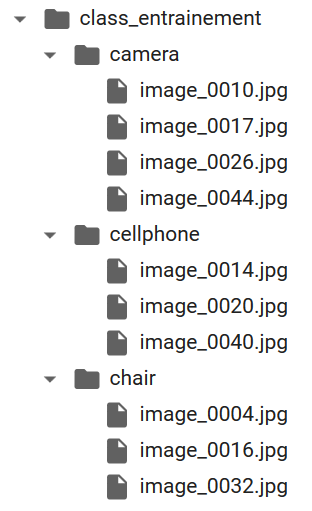


In [ ]:
#@markdown ## Entraînement sur un corpus 


#@markdown ### Importation du corpus d'entraînement 
#@markdown Entrer le chemin du dossier contenant les sous-dossiers correspondant aux classes :

dossier_entrainement = "" #@param {type:"string"}
#@markdown Exemple de chemin : /content/drive/MyDrive/classification/corpus_entrainement/

#@markdown ### Paramètres
#@markdown Entrer le nombre d'époques souhaité pour l'entrainement : 

num_epoques =  10#@param {type:"integer"}

preprocess = "Aucun" #@param ["Aucun", "Data Augmentation", "Drop Out 20 %", "Drop Out + Data Augmentation"]

data_dir = pathlib.Path(dossier_entrainement)
image_count = len(list(data_dir.glob('*/*.*')))
print("nombre d'images chargées : ", image_count)

# Définition des paramètres 
batch_size = 32
img_height = 180
img_width = 180

# Création de la partie TRAIN
print("Séparation du corpus Entraînement / Validation")
print("Création de la partie Entraînement")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Création de la partie VAL
print("Création de la partie Validation")
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print("Classes repérées : ", class_names)


#Performance : 
# Dataset.cache : conserver les images du dataset dans la mémoire après leur chargement à la première époque 
# Dataset.prefetch : gère les pré-traitements sur le corpus en même temps que l'éxécution du modèle
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255) # passer les valeurs RGB du channel de [0,255] à [0,1]

# Création du modèle
num_classes = len(class_names)

############################
## AUGMENTATION DE DONNEES##
if "Data" in preprocess :
  print("Augmentation des données d'entraînement")
  data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)
else : 
  pass
############################
print("Création du modèle")

if "Drop" in preprocess :
  model = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2), 
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
  ])
else :
  model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
  ])

# Compilation 
print("Compilation du modèle")
model.compile(optimizer='adam',         # OPTIMIZER
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Entraînement
print("Entraînement")
epochs = num_epoques
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

In [ ]:
#@markdown ### Visualisation de l'entraînement
#@markdown Lancer cette cellule pour visualiser la précision et la perte au fil des époques.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

La courbe Accuracy de l'entraînement doit augmenter au fil des époques.

La courbe Loss de l'entraînement doit diminuer au fil des époques.

Si la courbe de précision de la Validation stagne, et/ou que l'écart de précision entre Entrainement et Validation est important, il y a risque de sur-entraînement : s'il y a trop peu de données d'entraînement, le modèle peut considérer des détails impertinents qui porteront préjudice lors de la prédiction sur de nouvelles données. 

Le modèle créé sera alors particulièrement adapté aux données d'entraînement mais donnera de mauvais scores en généralisant sur d'autres données.

Les techniques de l'Augmentation de données et du Drop Out permettent de réduire l'effet de sur-entraînement :

L'augmentation des données consiste à générer des images d'entraînement supplémentaires en appliquant des transformations légères sur les images initiales. 

Le Drop Out consiste à abandonner certaines valeurs obtenues lors de l'entraînement (20 % ici).

In [ ]:
import pickle

#@markdown ### Sauvegarde du modèle
#@markdown Entrer le chemin d'un nouveau dossier sur le Google Drive où sauvegarder le modèle entraîné :

dossier_sauvegarde = "" #@param {type:"string"}
#@markdown Exemple de chemin : /content/drive/MyDrive/classification/modeles_entraines/modele123/

if not os.path.exists(dossier_sauvegarde) :
  os.makedirs(dossier_sauvegarde)
# Sauvegarde du modèle
model.save(dossier_sauvegarde)

# Sauvegarde des classes associées
with open(os.path.join(dossier_sauvegarde,'labels.pickle'), "wb") as f :
  f.write(pickle.dumps(class_names))
